In [20]:
#Import libraries 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
from math import pi

In [2]:
# Load the dataset
data = pd.read_csv("online_retail.csv")
# Display the first few rows of the dataset
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
#Data preprocessing
# Drop rows with missing CustomerID as it's crucial for identifying purchases
data.dropna(subset=['CustomerID'], inplace=True)

# Removing outliers for Quantity and UnitPrice
quantiles_quantity = data['Quantity'].quantile([0.01, 0.99])
data = data[(data['Quantity'] > quantiles_quantity[0.01]) & (data['Quantity'] < quantiles_quantity[0.99])]

quantiles_price = data['UnitPrice'].quantile([0.01, 0.99])
data = data[(data['UnitPrice'] > quantiles_price[0.01]) & (data['UnitPrice'] < quantiles_price[0.99])]

# Convert InvoiceDate to datetime and create new time-based features
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek


In [4]:
#Create new features that could be helpful for the model.
#let's focus on total monthly sales for each product
monthly_sales = data.groupby(['StockCode', 'Year', 'Month']).agg(TotalSales=('Quantity', 'sum')).reset_index()


In [5]:
#Preparaing data for modeling
# Assuming 'StockCode' is a categorical feature 
X = monthly_sales.drop(['TotalSales'], axis=1)
y = monthly_sales['TotalSales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We will use OneHotEncoder for 'StockCode' in a pipeline to avoid data leakage
categorical_features = ['StockCode']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

In [11]:
#Model selection and hyperparameter tuning 

# Hyperparameters to test for RandomForestRegressor
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("Best parameters for RandomForestRegressor:", grid_search_rf.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for RandomForestRegressor: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}


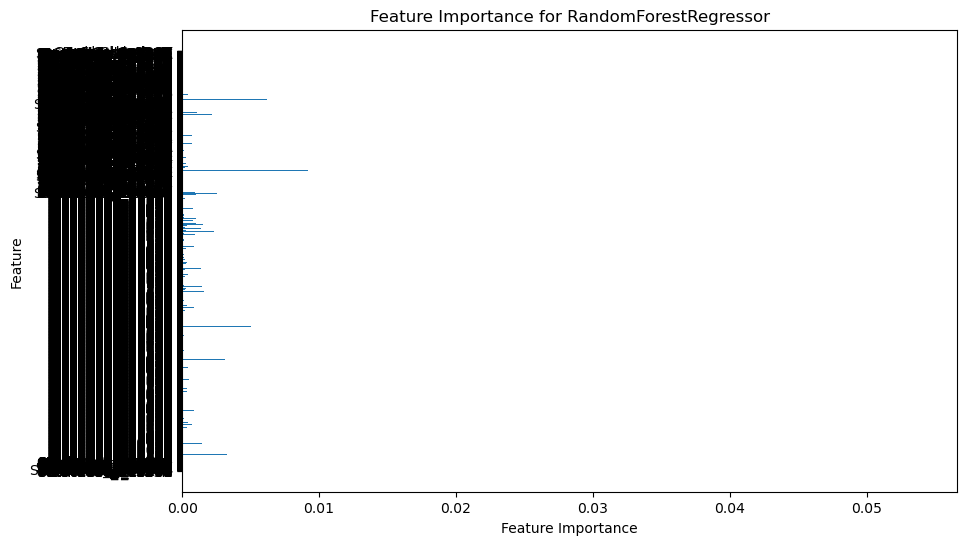

In [9]:
# Feature Importance Plot for RandomForestRegressor
#grid_search_rf.best_estimator_ is your trained RandomForest model
feature_importances = grid_search_rf.best_estimator_.named_steps['regressor'].feature_importances_

features = grid_search_rf.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), feature_importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForestRegressor')
plt.show()


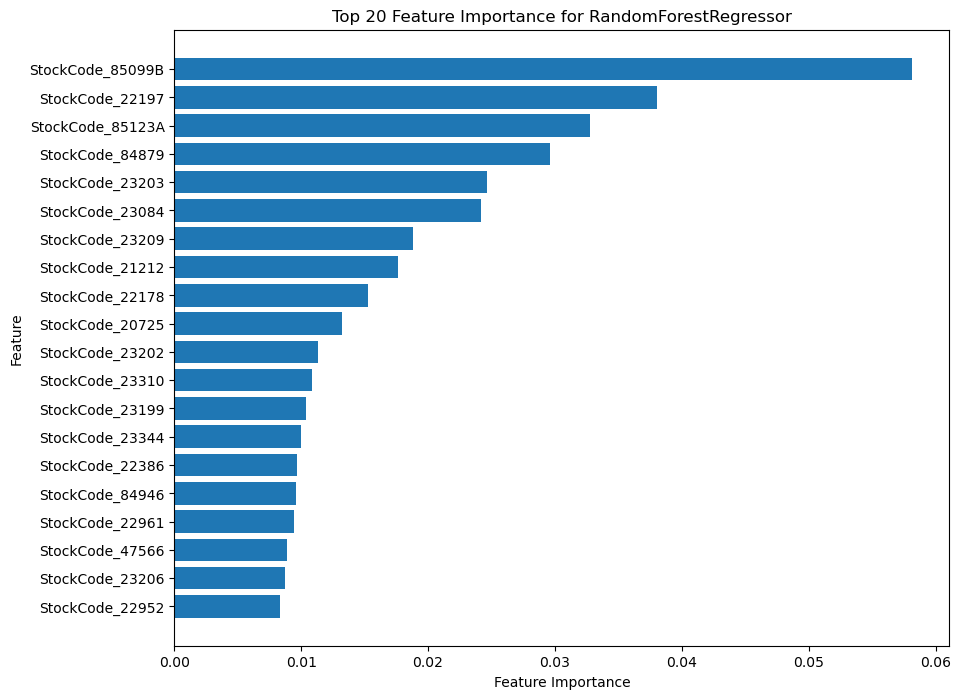

In [22]:
# Feature Importance Plot for RandomForestRegressor
#grid_search_rf.best_estimator_ is your trained RandomForest model
feature_importances = grid_search_rf.best_estimator_.named_steps['regressor'].feature_importances_

# Sort features by their importance
sorted_idx = feature_importances.argsort()

# Taking the top 20 features for readability
top_n = 20
sorted_idx_top = sorted_idx[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importances[sorted_idx_top], align='center')
plt.yticks(range(top_n), [features[i] for i in sorted_idx_top])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance for RandomForestRegressor')
plt.show()


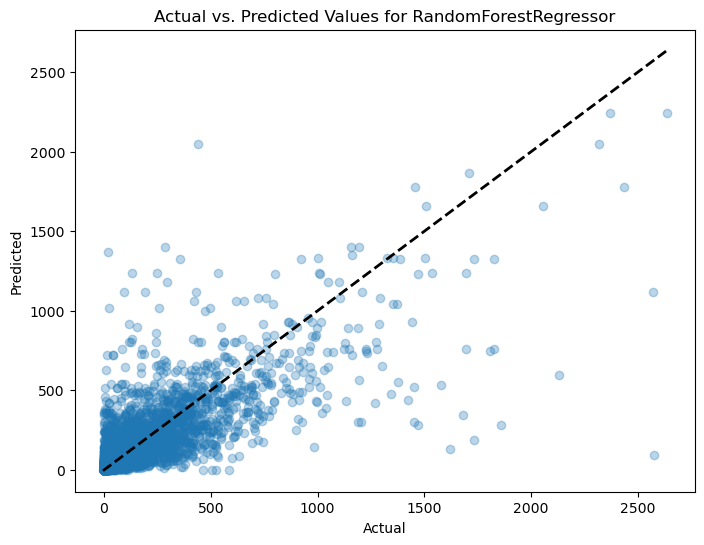

In [12]:
#Prediction vs. Actual Values Scatter Plot
#RandomForestRegressor predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values for RandomForestRegressor')
plt.show()


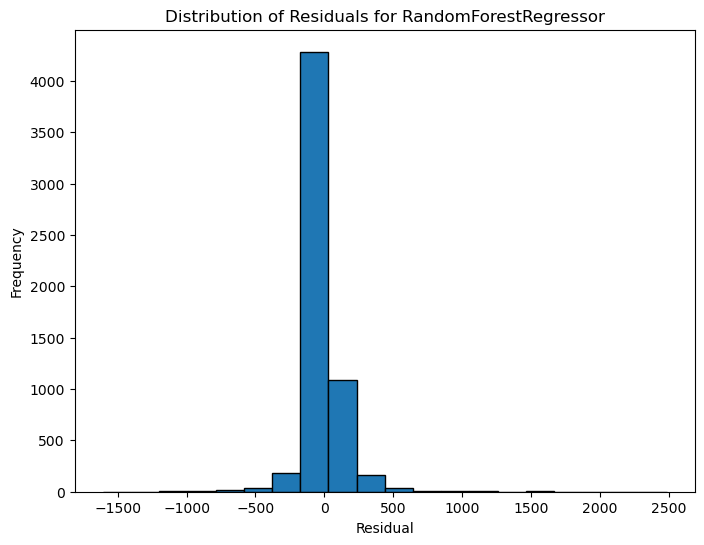

In [13]:
# Error Distribution Plot
# Calculating residuals for RandomForestRegressor
residuals_rf = y_test - y_pred_rf

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_rf, bins=20, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals for RandomForestRegressor')
plt.show()

In [10]:
# Hyperparameter to test for GradientBoostingRegressor
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', GradientBoostingRegressor())])

param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5],
}

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)

print("Best parameters for GradientBoostingRegressor:", grid_search_gb.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for GradientBoostingRegressor: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}


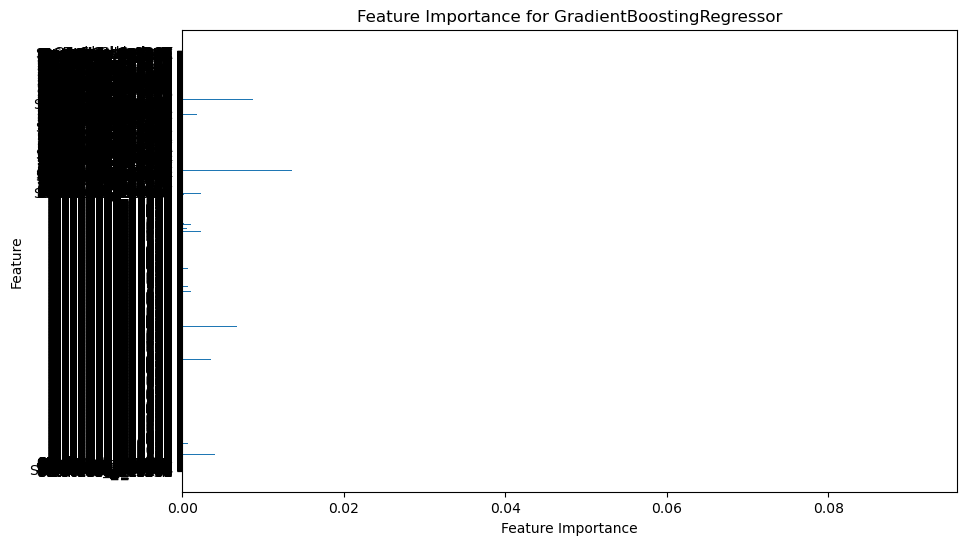

[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.0min
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.7min
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=200; tot

In [14]:
# Feature Importance Plot for GradientBoostingRegressor
# Extract feature importances
feature_importances_gb = grid_search_gb.best_estimator_.named_steps['regressor'].feature_importances_

features_gb = grid_search_gb.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features_gb)), feature_importances_gb, align='center')
plt.yticks(range(len(features_gb)), features_gb)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for GradientBoostingRegressor')
plt.show()

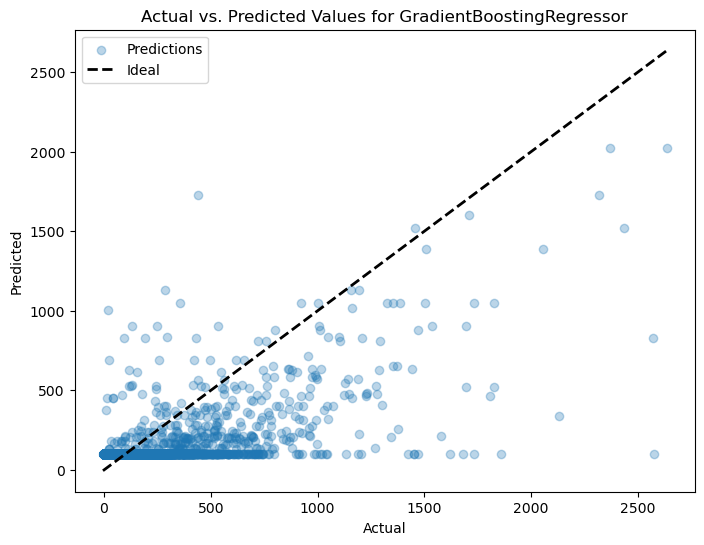

In [15]:
#Prediction vs. Actual Values Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.3, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values for GradientBoostingRegressor')
plt.legend()
plt.show()


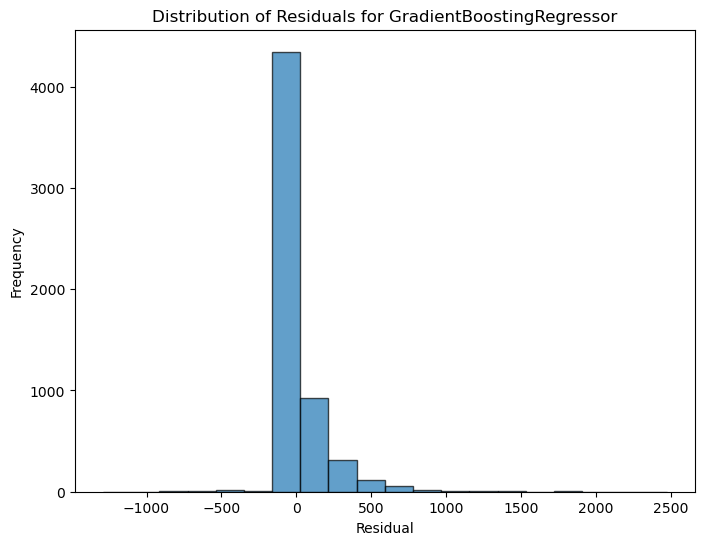

[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=200; total time=   0.9s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200; total time=   0.7s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time= 3.9min
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=200; total time= 3.5min
[CV] END regressor__max_depth=None, regressor__min_samples_split=10, regressor__n_estimators=200; total time= 2.9min
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; 

In [16]:
# Error Distribution Plot
# Calculate residuals
residuals_gb = y_test - y_pred_gb

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_gb, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals for GradientBoostingRegressor')
plt.show()


In [7]:
# Evaluate RandomForestRegressor
y_pred_rf = grid_search_rf.predict(X_test)
print("RandomForestRegressor Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("R^2:", r2_score(y_test, y_pred_rf))

# Evaluate GradientBoostingRegressor
y_pred_gb = grid_search_gb.predict(X_test)
print("GradientBoostingRegressor Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", mean_squared_error(y_test, y_pred_gb, squared=False))
print("R^2:", r2_score(y_test, y_pred_gb))

RandomForestRegressor Performance:
MAE: 67.17701450288268
RMSE: 142.51618331191528
R^2: 0.5947719133559952
GradientBoostingRegressor Performance:
MAE: 111.47783661919334
RMSE: 178.40105306453
R^2: 0.365011295420538


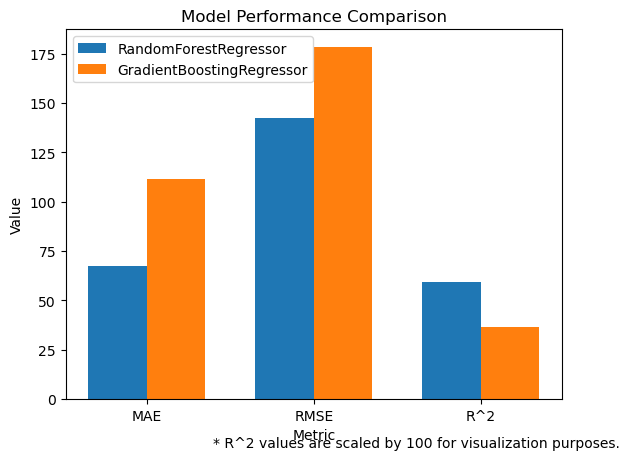

In [19]:
# Data preparation
metrics = ['MAE', 'RMSE', 'R^2']
values_rf = [metrics_rf['MAE'], metrics_rf['RMSE'], metrics_rf['R^2']]
values_gb = [metrics_gb['MAE'], metrics_gb['RMSE'], metrics_gb['R^2']]

# Making the R^2 value comparable in scale to MAE and RMSE for visualization purposes
values_rf[2] = values_rf[2] * 100  # Scaling R^2 value by 100
values_gb[2] = values_gb[2] * 100  # Scaling R^2 value by 100

n_metrics = len(metrics)
index = np.arange(n_metrics)
bar_width = 0.35

# Creating the bar chart
fig, ax = plt.subplots()
bar_rf = ax.bar(index, values_rf, bar_width, label='RandomForestRegressor')
bar_gb = ax.bar(index + bar_width, values_gb, bar_width, label='GradientBoostingRegressor')

# Adding labels, title, and legend
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Note about R^2 scaling
plt.figtext(0.99, 0.01, '* R^2 values are scaled by 100 for visualization purposes.', horizontalalignment='right')

plt.show()


In [8]:
# Model Evaluation Metrics
metrics_rf = {
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": mean_squared_error(y_test, y_pred_rf, squared=False),
    "R^2": r2_score(y_test, y_pred_rf)
}

metrics_gb = {
    "MAE": mean_absolute_error(y_test, y_pred_gb),
    "RMSE": mean_squared_error(y_test, y_pred_gb, squared=False),
    "R^2": r2_score(y_test, y_pred_gb)
}

# Display the performance metrics for both models
print("RandomForestRegressor Performance:")
print(f"MAE: {metrics_rf['MAE']:.2f}")
print(f"RMSE: {metrics_rf['RMSE']:.2f}")
print(f"R^2: {metrics_rf['R^2']:.2f}\n")

print("GradientBoostingRegressor Performance:")
print(f"MAE: {metrics_gb['MAE']:.2f}")
print(f"RMSE: {metrics_gb['RMSE']:.2f}")
print(f"R^2: {metrics_gb['R^2']:.2f}\n")

# Comparison
if metrics_rf["R^2"] > metrics_gb["R^2"]:
    print("RandomForestRegressor has a higher R^2, indicating potentially better performance on this dataset.")
elif metrics_rf["R^2"] < metrics_gb["R^2"]:
    print("GradientBoostingRegressor has a higher R^2, indicating potentially better performance on this dataset.")
else:
    print("Both models perform similarly in terms of R^2.")

# Further considerations based on MAE and RMSE can also be discussed
if metrics_rf["MAE"] < metrics_gb["MAE"] and metrics_rf["RMSE"] < metrics_gb["RMSE"]:
    print("RandomForestRegressor has lower MAE and RMSE, indicating more precise and reliable predictions.")
elif metrics_rf["MAE"] > metrics_gb["MAE"] and metrics_rf["RMSE"] > metrics_gb["RMSE"]:
    print("GradientBoostingRegressor has lower MAE and RMSE, indicating more precise and reliable predictions.")
else:
    print("The models have mixed results in terms of MAE and RMSE, suggesting different strengths.")


RandomForestRegressor Performance:
MAE: 67.18
RMSE: 142.52
R^2: 0.59

GradientBoostingRegressor Performance:
MAE: 111.48
RMSE: 178.40
R^2: 0.37

RandomForestRegressor has a higher R^2, indicating potentially better performance on this dataset.
RandomForestRegressor has lower MAE and RMSE, indicating more precise and reliable predictions.
[CV] END regressor__max_depth=None, regressor__n_estimators=100; total time= 2.0min
[CV] END regressor__max_depth=None, regressor__n_estimators=200; total time= 2.9min
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=200; total time=   1.0s
[CV] END regressor__learning_rate=0.1, regre

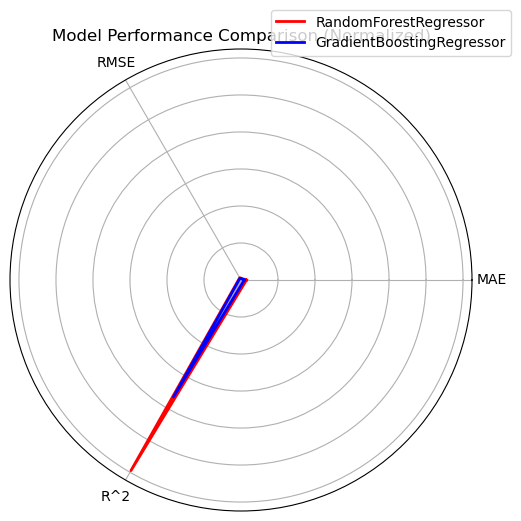

In [21]:
#Radar Chart for Model Performance Comparison:
# Define the metrics and their values for each model
metrics = ['MAE', 'RMSE', 'R^2']
values_rf = [metrics_rf['MAE'], metrics_rf['RMSE'], metrics_rf['R^2']]
values_gb = [metrics_gb['MAE'], metrics_gb['RMSE'], metrics_gb['R^2']]

# We need to normalize the RMSE and MAE as they are 'the lower, the better'
# Let's invert them by taking the reciprocal. For R^2, higher is better, so we leave it as is.
values_rf_normalized = [1/x if x != 0 else 0 for x in values_rf[:-1]] + [values_rf[-1]]
values_gb_normalized = [1/x if x != 0 else 0 for x in values_gb[:-1]] + [values_gb[-1]]

# Number of variables we're plotting
num_vars = len(metrics)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start value to the end.
values_rf_normalized += values_rf_normalized[:1]
values_gb_normalized += values_gb_normalized[:1]
angles += angles[:1]

# Draw the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values_rf_normalized, color='red', alpha=0.25)
ax.fill(angles, values_gb_normalized, color='blue', alpha=0.25)

# Add lines for each model
ax.plot(angles, values_rf_normalized, color='red', linewidth=2, label='RandomForestRegressor')
ax.plot(angles, values_gb_normalized, color='blue', linewidth=2, label='GradientBoostingRegressor')

# Labels for each metric
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Add a legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Model Performance Comparison (Normalized)')

plt.show()